In [11]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [12]:
T = 0.1
s = ctl.TransferFunction.s

In [13]:
C = (12.644352003932*s + 7.94468067299125)/(1.59154943091895*s**3 + 15.4300184675168*s**2 + 21.7110000056752*s + 7.94468067299125)
C

TransferFunction(array([12.644352  ,  7.94468067]), array([ 1.59154943, 15.43001847, 21.71100001,  7.94468067]))

In [14]:
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([ 0.02982629, -0.0059403 , -0.0207256 ]), array([ 1.        , -2.29107444,  1.67350872, -0.3792739 ]), 0.1)

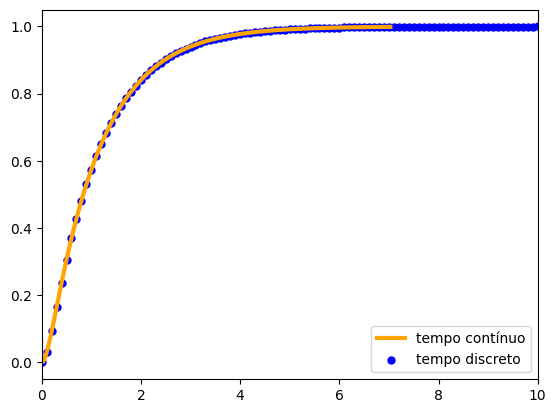

In [15]:
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.xlim([0, 10])
plt.legend()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

In [16]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[ 0.02982629 -0.0059403  -0.0207256 ]
[ 1.         -2.29107444  1.67350872 -0.3792739 ]


In [17]:
if type(num) == np.float64:
    num = np.array([num])

In [18]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

0.02982628808124943*X_n -0.00594030320783534*X_n1 -0.020725595965860044*X_n2 + 2.291074438625772*Y_n1-1.6735087238833164*Y_n2+ 0.37927389634999037*Y_n3;


In [19]:
Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = Y_n3 = 0

def computeController(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, Y_n3
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

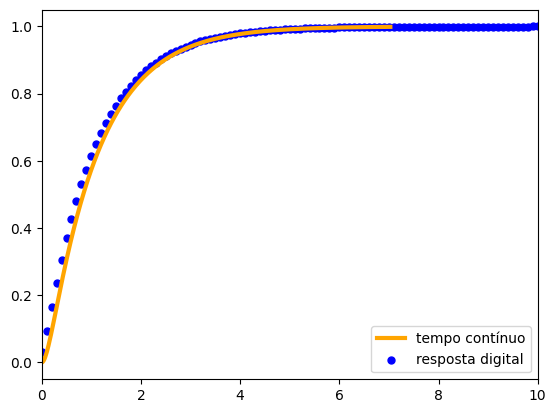

In [20]:
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = 0
X_n1 = X_n2 = 0
time     = np.arange(0, 20, T)
response = [computeController(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.xlim([0, 10])
plt.legend()
plt.show()

# TESTANDO NOS DADOS DISCRETOS

In [21]:
def normalizeData(time, response, T=0.01):
    timeIntervals = np.arange(np.min(time), np.max(time), T)
    xData = []
    yData = []

    for i in range(len(timeIntervals) - 1):
        position      = timeIntervals[i]
        next_position = timeIntervals[i + 1]

        target = response[(time > position) & (time <= next_position)]
        
        if len(target) == 0:
            continue
        
        t = (next_position + position)/2
        y = np.min(target)

        xData.append(t)
        yData.append(y)

    return xData, yData

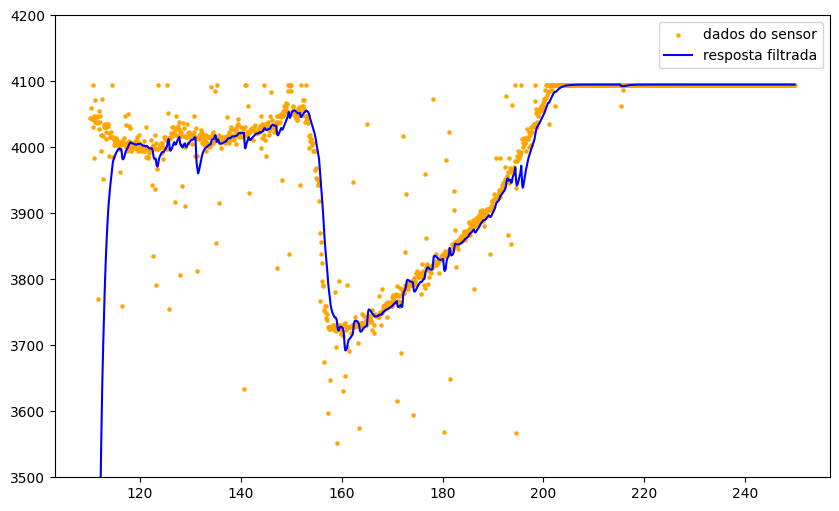

In [22]:
df = pd.read_csv('DataBase.csv')
df = df.loc[(df['time'] > 110) & (df['time'] < 250)]

xData = df['time'].to_numpy()
yData = df['analog'].to_numpy()

xData, yData = normalizeData(xData, yData, T=0.1)
plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, s=5, color='orange', label='dados do sensor')

Y_n1 = Y_n2 = 0
X_n1 = X_n2 = 0
response = [computeController(val) for val in yData] 
plt.plot(xData, response, color='blue', label='resposta filtrada')
plt.ylim(3500, 4200)
plt.legend()
plt.show()